# Image transformations

This notebook shows new features of torchvision image transformations. 

Prior to v0.8.0, transforms in torchvision have traditionally been PIL-centric and presented multiple limitations due to that. Now, since v0.8.0, transforms implementations are Tensor and PIL compatible and we can achieve the following new 
features:
- transform multi-band torch tensor images (with more than 3-4 channels) 
- torch script transforms together with your model for deployment
- support for GPU acceleration
- batched transformation such as for videos
- read and decode data directly as torch tensor with torch script support (for PNG and JPEG image formats)

In [1]:
# TO REMOVE ONCE v0.8.0 RELEASED

# !python -m pip install --pre --upgrade -q torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
# !conda install -y pytorch torchvision -c pytorch-nightly

# restart runtime: ctrl/cmd+m+,

In [2]:
import torch, torchvision
torch.__version__, torchvision.__version__

('1.8.0.dev20201006', '0.8.0.dev20201006')

## Transforms on CPU/CUDA tensor images

Let's show how to apply transformations on images opened directly as a torch tensors.
Now, torchvision provides image reading functions for PNG and JPG images with torchscript support. 

In [3]:
from torchvision.datasets.utils import download_url

download_url("https://farm1.static.flickr.com/152/434505223_8d1890e1e2.jpg", ".", "test-image.jpg")
download_url("https://farm3.static.flickr.com/2142/1896267403_24939864ba.jpg", ".", "test-image2.jpg")

Using downloaded and verified file: ./test-image.jpg
Using downloaded and verified file: ./test-image2.jpg


In [4]:
import matplotlib.pylab as plt
%matplotlib inline

tensor image info:  torch.Size([3, 323, 500]) torch.uint8


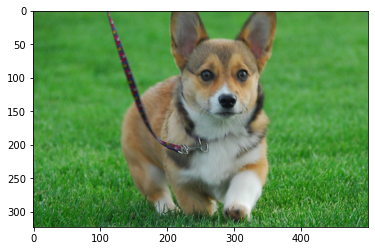

In [5]:
from torchvision.io.image import read_image

tensor_image = read_image("test-image.jpg")

print("tensor image info: ", tensor_image.shape, tensor_image.dtype)

plt.imshow(tensor_image.numpy().transpose((1, 2, 0)))

In [12]:
def to_rgb_image(tensor):
    """Helper method to get RGB numpy array for plotting"""
    np_img = tensor.cpu().numpy().transpose((1, 2, 0))
    m1, m2 = np_img.min(axis=(0, 1)), np_img.max(axis=(0, 1))
    return (255.0 * (np_img - m1) / (m2 - m1)).astype("uint8")

output tensor image info:  torch.Size([3, 224, 224]) torch.float32


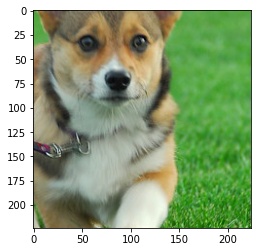

In [20]:
import torchvision.transforms as T

# to fix random seed is now:
torch.manual_seed(12)

transforms = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
    T.ConvertImageDtype(torch.float),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

out_image = transforms(tensor_image)
print("output tensor image info: ", out_image.shape, out_image.dtype)

plt.imshow(to_rgb_image(out_image))

Tensor images can be on GPU

output tensor image info:  torch.Size([3, 224, 224]) torch.float32 cuda:0


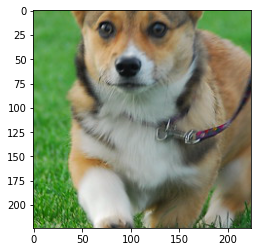

In [21]:
out_image = transforms(tensor_image.to("cuda"))
print("output tensor image info: ", out_image.shape, out_image.dtype, out_image.device)

plt.imshow(to_rgb_image(out_image))

## Scriptable transforms for easier deployment via torchscript

Next, we show how to combine input transformations and model's forward pass and use `torch.jit.script` to obtain a single scripted module.

**Note:** we have to use only scriptable transformations that should be derived from `torch.nn.Module`. 
Since v0.8.0, all transformations are scriptable except `Compose`, `RandomApply`, `RandomChoice`, `RandomOrder`, `Lambda` and those applied on PIL images. 
The transformations like `Compose` are kept for backward compatibility and can be easily replaced by existing torch modules, like `nn.Sequential`.

Let's define a module `Predictor` that transforms input tensor and applies ImageNet pretrained resnet18 model on it.

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io.image import read_image
from torchvision.models import resnet18


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(pretrained=True).eval()
        self.transforms = nn.Sequential(
            T.Resize(256),
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.transforms(x)
        y_pred = self.resnet18(x)
        return y_pred.argmax(dim=1)

Now, let's define scripted and non-scripted instances of `Predictor` and apply on multiple tensor images of the same size

In [23]:
from torchvision.io.image import read_image

predictor = Predictor().to("cuda")
scripted_predictor = torch.jit.script(predictor).to("cuda")


tensor_image1 = read_image("test-image.jpg")
tensor_image2 = read_image("test-image2.jpg")
batch = torch.stack([tensor_image1[:, -320:, :], tensor_image2[:, -320:, :]]).to("cuda")

res1 = scripted_predictor(batch)
res2 = predictor(batch)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Using downloaded and verified file: ./imagenet_class_index.json


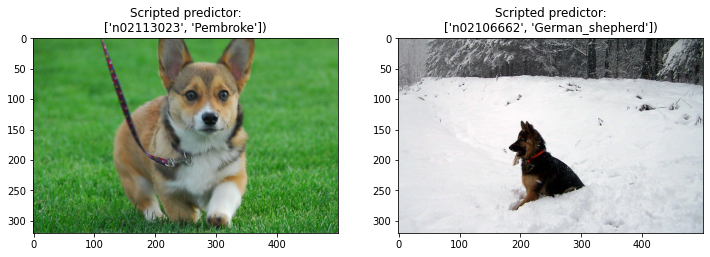

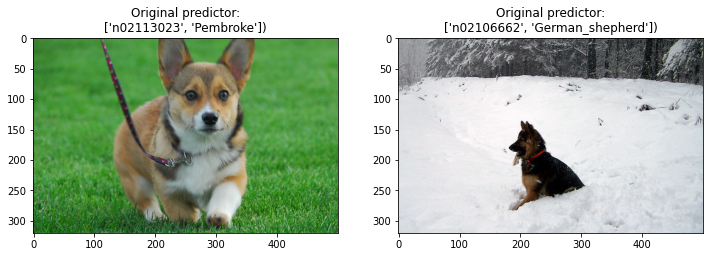

In [28]:
import json
from torchvision.datasets.utils import download_url


download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")


with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)


plt.figure(figsize=(12, 7))
for i, p in enumerate(res1):
    plt.subplot(1, 2, i + 1)
    plt.title("Scripted predictor:\n{label})".format(label=labels[str(p.item())]))
    plt.imshow(batch[i, ...].cpu().numpy().transpose((1, 2, 0)))


plt.figure(figsize=(12, 7))
for i, p in enumerate(res2):
    plt.subplot(1, 2, i + 1)
    plt.title("Original predictor:\n{label})".format(label=labels[str(p.item())]))
    plt.imshow(batch[i, ...].cpu().numpy().transpose((1, 2, 0)))

We save and reload scripted predictor in Python or C++ and use it for inference:

In [29]:
scripted_predictor.save("scripted_predictor.pt")

scripted_predictor = torch.jit.load("scripted_predictor.pt")
res1 = scripted_predictor(batch)

for i, p in enumerate(res1):
    print("Scripted predictor: {label})".format(label=labels[str(p.item())]))


Scripted predictor: ['n02113023', 'Pembroke'])
Scripted predictor: ['n02106662', 'German_shepherd'])


Data reading and decoding functions also support torch script and therefore can be part of the model as well:

In [37]:
class AnotherPredictor(Predictor):

    @torch.no_grad()
    def forward(self, path: str) -> torch.Tensor:
        x = read_image(path).unsqueeze(0)
        return super().forward(x).item()

In [39]:
# TODO: replace once nightly contains scriptable read_image
# scripted_predictor2 = torch.jit.script(AnotherPredictor()).to("cuda")
scripted_predictor2 = AnotherPredictor()

res = scripted_predictor2("test-image.jpg")

print("Scripted another predictor: {label})".format(label=labels[str(res)]))

Scripted another predictor: ['n02113023', 'Pembroke'])


## Transforms on tensors for video input

TODO